#Algoritmos Redes Neuronales Siamesas 

##Declaración de Librerías

In [1]:
# Declaramos las librerías necesarias 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import files
from zipfile import ZipFile
import os
import glob
import cv2 as cv
import shutil
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import pickle
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization
from keras import metrics
from keras.metrics import categorical_crossentropy

## Upload de las imágenes y preparación de los directorios

In [2]:
# Subimos el dataset 
# NGC40 - es un dataset compuesto de 40 imágenes de Galaxias y copias de estas
# con aumentos y rotaciones realizadas con la librería Augmentor
uploaded = files.upload()

Saving NGC40.zip to NGC40.zip


In [3]:
!mkdir /content/datangc

In [6]:
# Extraemos las imágenes del Zip en el directorio creado
with ZipFile('NGC40.zip', 'r') as zipObj:
   zipObj.extractall('datangc')

In [7]:
os.listdir('/content/datangc/')

['s27',
 's12',
 's14',
 's4',
 's35',
 's11',
 's8',
 's37',
 's19',
 's7',
 's13',
 's38',
 's5',
 's21',
 's32',
 's6',
 's39',
 's31',
 's2',
 's34',
 's23',
 's9',
 's28',
 's30',
 's29',
 's25',
 's20',
 's22',
 's40',
 's10',
 's18',
 's26',
 's1',
 's3',
 's33',
 's17',
 's15',
 's24',
 's16',
 's36']

## Lectura y Visualización de imágenes

In [8]:
# Procedemos a leer las imágenes del dataset y les asignamos la etiqueta según
# la Galaxia que es mediante la serie s1 .... s40
cv_img = []
name_galax = []

for i in range(41):
  path = glob.glob("/content/datangc/s"+ str(i) +"/*.jpg")
  for img in path:
    name_galax.append(str(i))
    #n = cv.imread(img)
    #cv_img.append(rgb2gray(n))
    #cv_img.append(n)
    image = cv.imread(img, cv.IMREAD_GRAYSCALE)
    image = np.reshape(image, (160, 160, 1))
    image = image / 255
    cv_img.append(image)

In [9]:
# Creamos el dataset de training y de test
y = np.array(name_galax)
X = np.array(cv_img)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [10]:
print("train: " + str(x_train.shape))
print("test: " + str(x_test.shape))
print("train y: " + str(y_train.shape))
print("test y: " + str(y_test.shape))

train: (574, 160, 160, 1)
test: (144, 160, 160, 1)
train y: (574,)
test y: (144,)


In [11]:
# Realizamos reshape para generar el batch de imágenes 
x_train = np.reshape(x_train, (x_train.shape[0], 25600))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 25600))/255.
print(x_train.shape)

(574, 25600)


In [12]:
# Creamos una función para ver los triplets que montaremos
def plot_triplets(examples):
    plt.figure(figsize=(8, 8))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (160, 160)), cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
    plt.show()

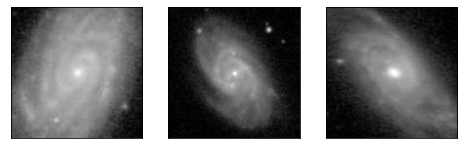

In [13]:
# Por ejemplo sacamos estas imágenes para verificar que la función funciona
plot_triplets([x_train[103], x_train[13], x_train[27]])

In [14]:
# Creamos la función create batch para generar los triplets que utilizaremos
# en el entrenamiento
def create_batch(batch_size=256):
    s = 76800  # 784
    x_anchors = []
    x_positives = []
    x_negatives = []
    
    for i in range(batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        x_anchors.append(np.reshape(x_anchor, (160,160,1)))
        x_positives.append(np.reshape(x_positive, (160,160,1)))
        x_negatives.append(np.reshape(x_negative, (160,160,1)))
        
        
    return [x_anchors, x_positives, x_negatives]

In [15]:
# Hacemos una prueba de crear 4 batches
batch_size = 4
anchor_image, positive_image, negative_image = create_batch(batch_size)

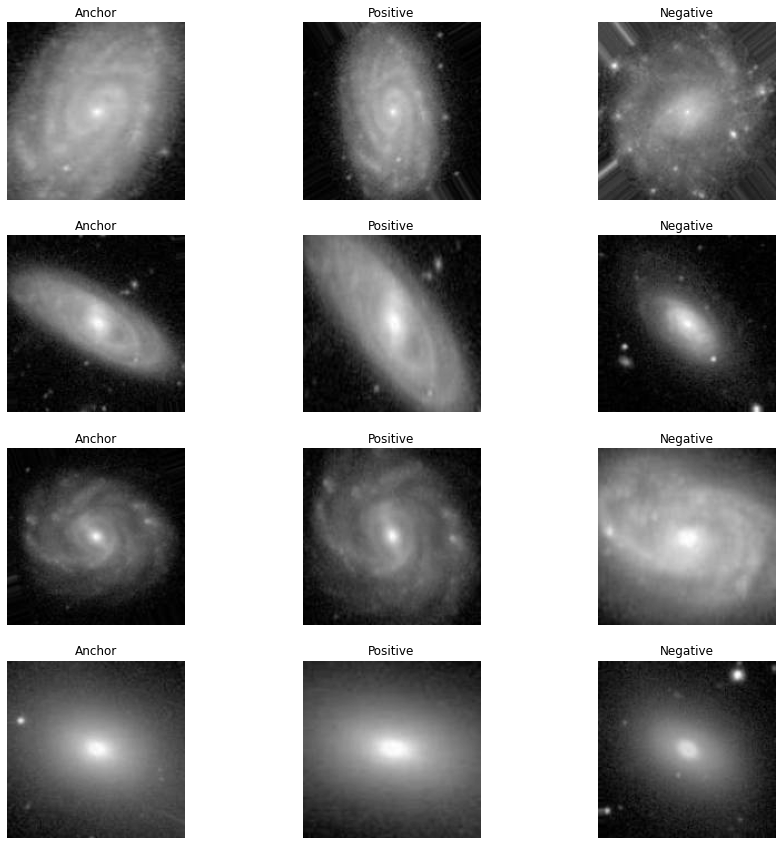

In [16]:
#  A continuación mostralos los resultados del batch de tamaño 4 con los 
# triplets, veremos el anchor, el positivo que es una variante del anterior
# pero es la misma galaxia y un tercero que es el negativo y que es totalmente
# diferente
fig, ax = plt.subplots(nrows=batch_size, ncols=3, figsize=(15,15))
for i in range(batch_size):
    ax[i, 0].imshow(np.reshape(anchor_image[i], (160, 160)),cmap=plt.cm.gray)
    ax[i, 0].set_title("Anchor")
    ax[i, 0].axis('off')
    ax[i, 1].imshow(np.reshape(positive_image[i], (160, 160)), cmap=plt.cm.gray)
    ax[i, 1].set_title("Positive")
    ax[i, 1].axis('off')
    ax[i, 2].imshow(np.reshape(negative_image[i], (160, 160)), cmap=plt.cm.gray)
    ax[i, 2].set_title("Negative")
    ax[i, 2].axis('off')
plt.show()

## Preparamos los Algoritmos de entrenamiento dependiendo el caso de estudio - Redes Neuronales Convolucionales (CNN), en este caso Dataset preparado para realizar Redes Neuronales Siamesas

In [17]:
# Preparamos el embedding o el vector de caracteríticas de los diferentes 
# triplets que extraeremos en cada batch size mediante la siguiente CNN
emb_size = 64
embedding_model = Sequential()
embedding_model.add(Conv2D(32, (1,1), activation='relu', strides=(1,1), input_shape=(160,160,1)))
embedding_model.add(BatchNormalization())
#embedding_model.add(MaxPooling2D())
# embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(64, (1,1), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(128, (1,1), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(Flatten())
embedding_model.add(Dense(emb_size, activation='sigmoid'))
embedding_model.add(Lambda(lambda x:tf.keras.backend.l2_normalize(x, axis=1)))
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      64        
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 160, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 64)      2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 128)     8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 128)     5

In [ ]:
# test_embedding_output1 = embedding_model.predict(np.expand_dims(anchor_image[3], axis=0))
# test_embedding_output2 = embedding_model.predict(np.expand_dims(positive_image[3], axis=0))
# test_embedding_output3 = embedding_model.predict(np.expand_dims(negative_image[3], axis=0))
# print(test_embedding_output1.shape)
# distance1 = tf.sqrt(tf.reduce_sum(tf.pow(test_embedding_output1 - test_embedding_output2, 2), 1, keepdims=True))
# distance2 = tf.sqrt(tf.reduce_sum(tf.pow(test_embedding_output1 - test_embedding_output3, 2), 1, keepdims=True))
# loss = tf.reduce_mean(tf.maximum(distance1 - distance2 + 0.2, 0.))
# distance1, distance2, loss

In [ ]:

# def identity_loss(y_true, y_pred):
#     return K.mean(y_pred)

# def triplet_loss(x, alpha = 0.2):
#     # Triplet Loss function.
#     anchor,positive,negative = x
#     # distance between the anchor and the positive
#     pos_dist = K.sum(K.square(anchor-positive),axis=1)
#     # distance between the anchor and the negative
#     neg_dist = K.sum(K.square(anchor-negative),axis=1)
#     # compute loss
#     basic_loss = pos_dist-neg_dist+alpha
#     loss = K.maximum(basic_loss,0.0)
#     return loss

In [18]:
# A continuación preparamos el modelo de la red siamesa
# A cada input le asignamos el vector de características y finalmente
# concatenamos para obtener el output de la red
from keras import backend as K
input_shape = (160,160,1)
input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output_concatenate = concatenate([embedding_anchor, embedding_positive, 
                                  embedding_negative], axis=1)
#loss = Lambda(triplet_loss)([embedding_anchor,embedding_positive,embedding_negative])
siamese_net = Model(
    [input_anchor, input_positive, input_negative],
    output_concatenate
)

siamese_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           209726656   input_1[0][0]                    
                                                                 input_2[0][0]         

In [19]:
# A continuación creamos la función de pérdida mediante la diferencia 
# de distancias de los triplets potenciando las distancias de los que son 
# iguales y ampliando las distancias si son diferentes
# L2 Distance
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.0))       
    return loss

In [20]:
# Generamos los batch cada uno con sus triplets (anchor, positive y negative)
def data_generator(batch_size, emb_size):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

In [21]:
batch_size = 32
epochs = 5
opt = tf.keras.optimizers.Adam(lr = 0.0001)
steps_per_epoch = 20
siamese_net.compile(loss=triplet_loss(alpha=0.8, emb_dim=emb_size), optimizer=opt, metrics=['accuracy'])
#siamese_net.compile(loss=identity_loss, optimizer=opt, metrics=['accuracy'])
siamese_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           209726656   input_1[0][0]                    
                                                                 input_2[0][0]         

In [22]:
history = siamese_net.fit(
    data_generator(batch_size, emb_size),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

Epoch 1/5
20/20 [==============================] - 47s 2s/step - loss: 0.7812 - accuracy: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 50s 3s/step - loss: 0.8066 - accuracy: 0.0000e+00
Epoch 3/5
20/20 [==============================] - 48s 2s/step - loss: 0.8198 - accuracy: 0.0000e+00
Epoch 4/5
20/20 [==============================] - 50s 2s/step - loss: nan - accuracy: 0.1500
Epoch 5/5
20/20 [==============================] - 48s 2s/step - loss: nan - accuracy: 1.0000


In [23]:
print(history.history['loss'])

[0.7812197208404541, 0.806592583656311, 0.8198195695877075, nan, nan]


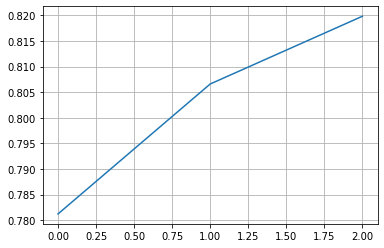

In [25]:
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()